In [1]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# External classes
from BufferGeometry import BufferGeometry
#from utils.analysis import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import linalg as la
from numpy.linalg import matrix_rank
import seaborn as sns

import torch
import torch.nn.functional as F

In [2]:
# Initialize tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()

def get_buffer_states(prompt):
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs.input_ids

    with torch.no_grad():
        outputs = model(input_ids, output_hidden_states=True, return_dict=True)
    
    hidden_states = outputs.hidden_states

    # Extract buffer states
    buffer_states = np.array([layer.squeeze(0).numpy() for layer in hidden_states])

    return buffer_states


# Initialize result containers
volumes = []
gd = []
cos_sim = []
mean_vector = []
rank_matrix = {}

# Read prompts from file
with open("prompts.txt", "r") as f:
    prompts = [line.strip() for line in f.readlines() if line.strip()]

# Loop over the prompts
for p in prompts:
    # Define matrices to store the results for each prompt
    phrase_volumes = []
    phrase_gd = []
    phrase_cos_sim = []
    phrase_mean_vector = []
    rank_matrix[p] = []
    phrase_rank_matrix = []

    # Get the buffer state 
    buffer_states = get_buffer_states(p)

    # Initial Grassmann reference buffer (from first step)
    buffer_scaled_0 = buffer_states[0,:,:] - np.mean(buffer_states[0,:,:], axis=0, keepdims=True)
    U, S, Vt = la.svd(buffer_scaled_0)
    eigenvalues = S**2
    explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
    n_components = np.argmax(np.cumsum(explained_variance_ratio) >= 0.9)+1

    U_reduced = U[:, :n_components]
    S_reduced = np.diag(S[:n_components])
    Vt_reduced = Vt[:n_components, :]
    buffer_reduced_0 = np.dot(np.dot(U_reduced, S_reduced), Vt_reduced)

    # Loop over buffer steps
    for i in range(buffer_states.shape[0]):
        bg = BufferGeometry(buffer_states[i, :, :])

        # ===== VOLUME =====
        phrase_volumes.append(bg.volume())

        # ===== COSINE SIMILARITY =====
        phrase_cos_sim.append(bg.cosine_similarity(buffer_states[-1, :, :]))

        # ===== MEAN VECTOR =====
        phrase_mean_vector.append(bg.mean_vector())

        # Reduce current buffer
        buffer_scaled = buffer_states[i,:,:] - np.mean(buffer_states[i,:,:], axis=0, keepdims=True)
        U, S, Vt = la.svd(buffer_scaled)
        eigenvalues = S**2
        explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
        n_components = np.argmax(np.cumsum(explained_variance_ratio) >= 0.9)+1

        U_reduced = U[:, :n_components]
        S_reduced = np.diag(S[:n_components])
        Vt_reduced = Vt[:n_components, :]
        buffer_reduced = np.dot(np.dot(U_reduced, S_reduced), Vt_reduced)

        # ===== GRASSMANN DISTANCE =====
        bg_reduced = BufferGeometry(buffer_reduced)
        phrase_gd.append(bg_reduced.grassmann_distance(buffer_reduced_0))

        # Update reference buffer
        buffer_reduced_0 = buffer_reduced

        # ===== RANK MATRIX =====
        Q = bg.extract_Q()
        phrase_rank_matrix = np.vstack(Q)


    # Append results for this phrase
    volumes.append(phrase_volumes)
    gd.append(phrase_gd)
    cos_sim.append(phrase_cos_sim)
    mean_vector.append(phrase_mean_vector)
    rank_matrix[p].append(phrase_rank_matrix)

    print(buffer_states.shape)

# Convert to NumPy arrays
volumes = np.array(volumes)
gd = np.array(gd)
cos_sim = np.array(cos_sim)
mean_vector = np.array(mean_vector)

(13, 6, 768)
(13, 10, 768)
(13, 13, 768)
(13, 21, 768)
(13, 25, 768)
(13, 31, 768)
(13, 38, 768)
(13, 44, 768)
(13, 60, 768)
(13, 88, 768)


In [3]:
# Count words in each prompt
word_counts = [len(prompt.split()) for prompt in prompts]
word_counts

print()

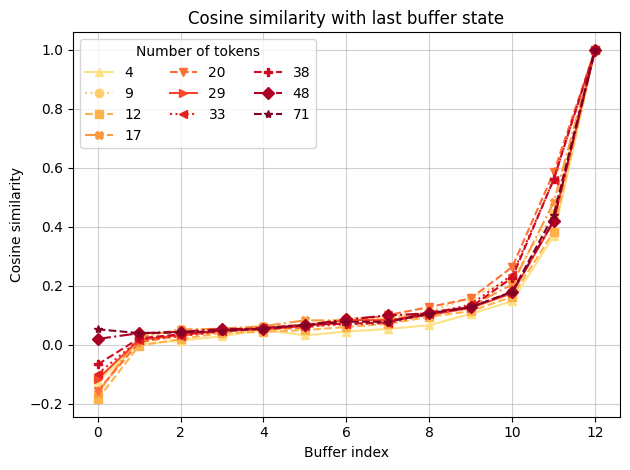

In [4]:
# --- Cosine Similarity Plot ---

colormap_name="YlOrRd"
cmap = plt.colormaps[colormap_name]
color_positions = np.linspace(0.2, 1, 10)
colors = [cmap(pos) for pos in color_positions]
markers = ["^", "o", "s", "X", "v", ">", "<", "P", "D", "*"]
linestyles = ["solid", "dotted", "dashed", "dashdot", "dashed"]*2


plt.figure()
for i in range(cos_sim.shape[0]):
    color = colors[i]
    marker = markers[i]
    linestyle = linestyles[i]
    
    plt.plot(range(cos_sim.shape[1]), cos_sim[i], color=color, marker=marker, linestyle=linestyle, label=f"{word_counts[i]}")
plt.title("Cosine similarity with last buffer state")
plt.xlabel("Buffer index")
plt.ylabel("Cosine similarity")
plt.grid(alpha=0.6)
plt.legend(loc="best", title="Number of tokens", ncol=3)
plt.tight_layout()
plt.show()

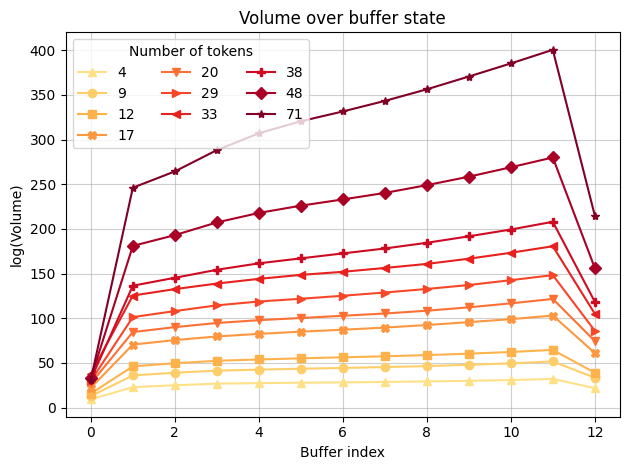

In [5]:
# --- Volume Plot ---
plt.figure()
for i in range(volumes.shape[0]):
    volumes.shape[1]
    color = colors[i]
    marker = markers[i]
    linestyle = linestyles[i]

    plt.plot(range(volumes.shape[1]), volumes[i], color=color, marker=marker, label=f"{word_counts[i]}")
    
plt.title("Volume over buffer state")
plt.xlabel("Buffer index")
plt.ylabel("log(Volume)")
#plt.yscale("log")
plt.grid(alpha=0.6)
plt.legend(loc="best", title="Number of tokens", ncol=3)
plt.tight_layout()
plt.show()

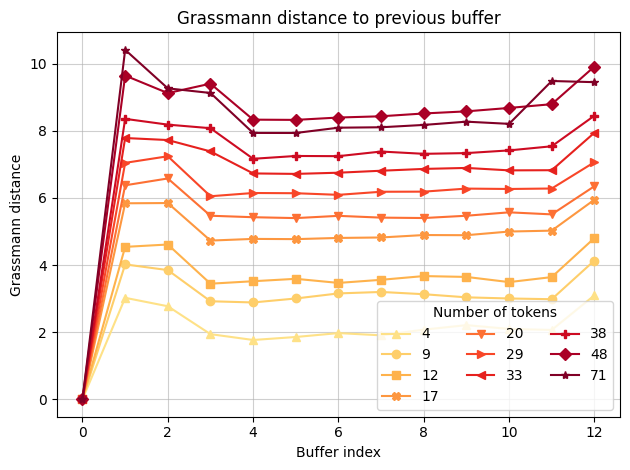

In [6]:
# --- Grassmann Distance Plot ---
plt.figure()
for i in range(gd.shape[0]):
    color = colors[i]
    marker = markers[i]
    linestyle = linestyles[i]

    plt.plot(range(gd.shape[1]), gd[i], color=color, marker=marker, label=f"{word_counts[i]}")
    
plt.title("Grassmann distance to previous buffer")
plt.xlabel("Buffer index")
plt.ylabel("Grassmann distance")
plt.grid(alpha=0.6)
plt.legend(loc="best", title="Number of tokens", ncol=3)
plt.tight_layout()
plt.show()

In [7]:
np.shape(mean_vector)

(10, 13, 768)

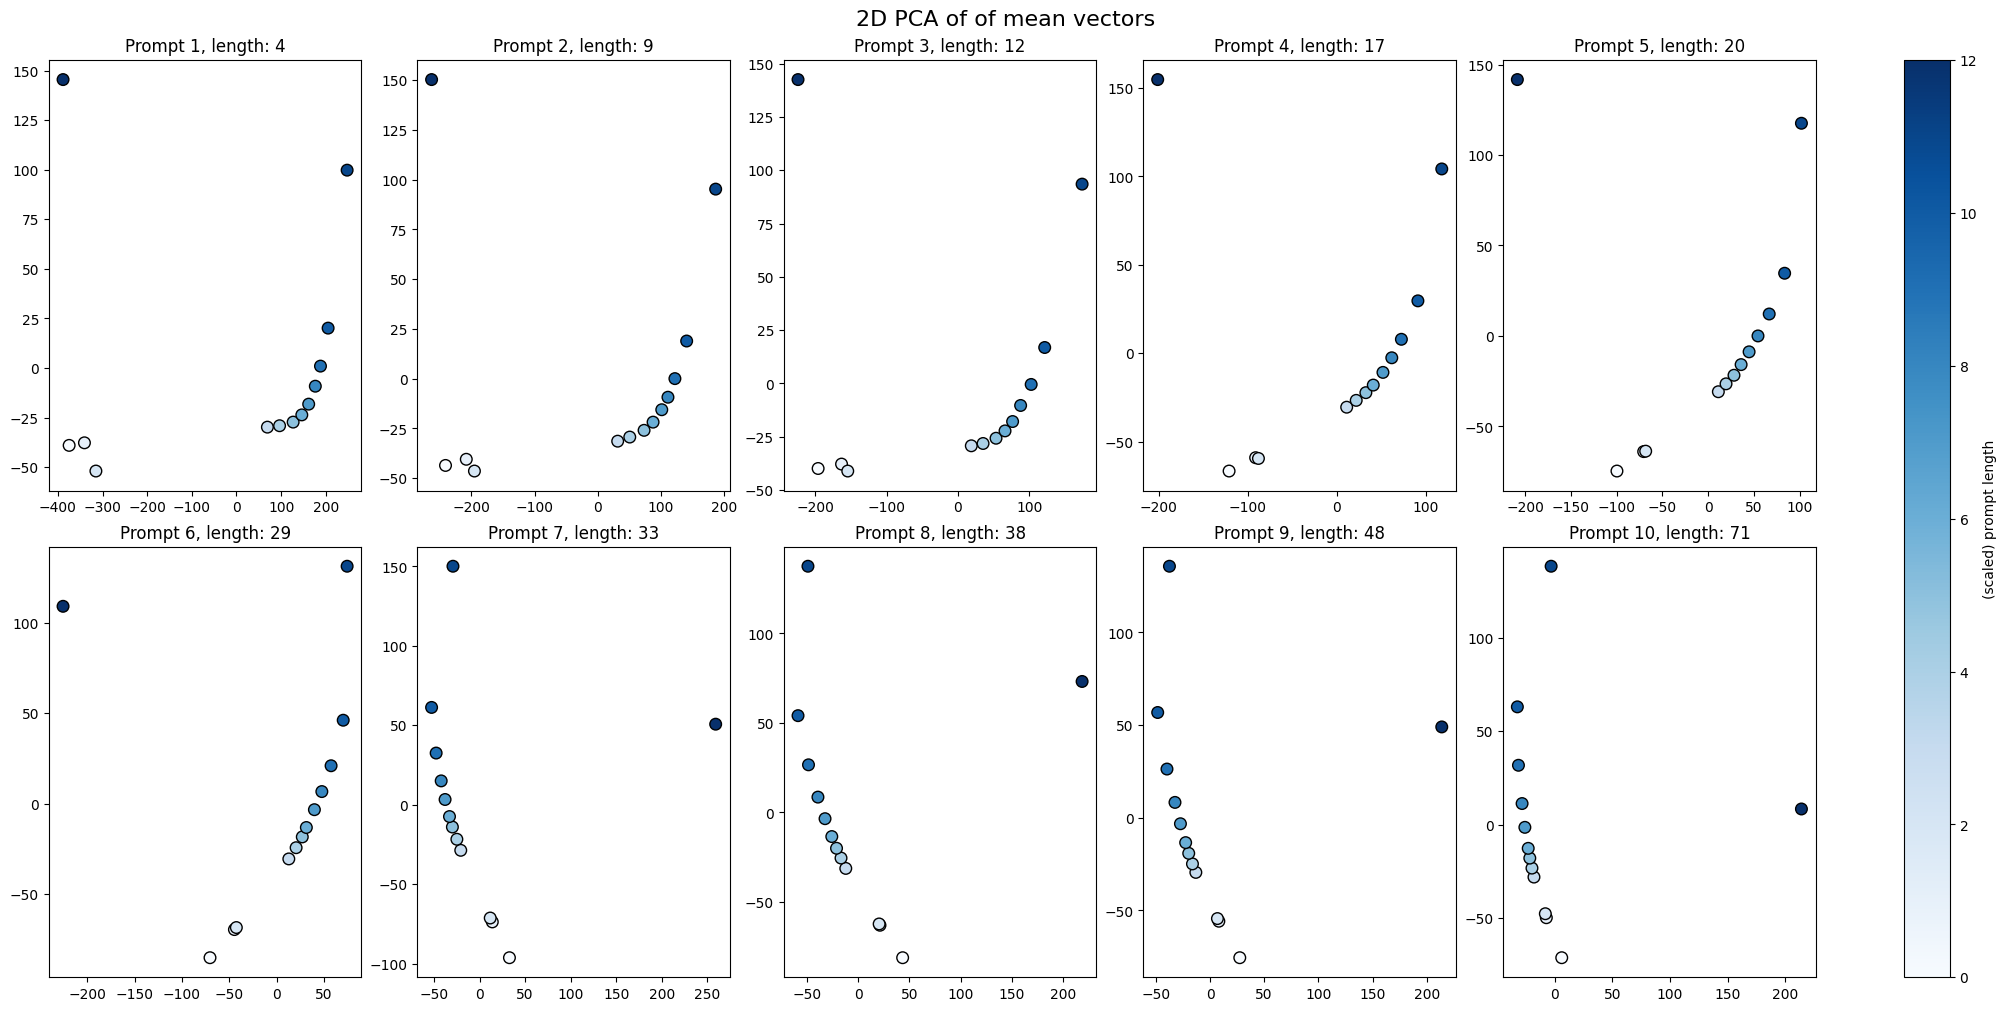

In [8]:
# Create subplots
fig, axs = plt.subplots(2, 5, figsize=(20, 10), constrained_layout=True)
axs = axs.flatten()

num_points = mean_vector.shape[1]
colors = np.arange(num_points)

for i in range(10):
    fixed_mean_vector = mean_vector[i, :, :]
    
    pca = PCA(n_components=2)
    proj = pca.fit_transform(fixed_mean_vector)
    
    scatter = axs[i].scatter(proj[:, 0], proj[:, 1], c=colors, cmap="Blues", s=70, edgecolor="black")
    axs[i].set_title(f"Prompt {i+1}, length: {word_counts[i]}")

# Shared colorbar
cbar = fig.colorbar(scatter, ax=axs, label="(scaled) prompt length")
fig.suptitle("2D PCA of of mean vectors", fontsize=16)
plt.show()

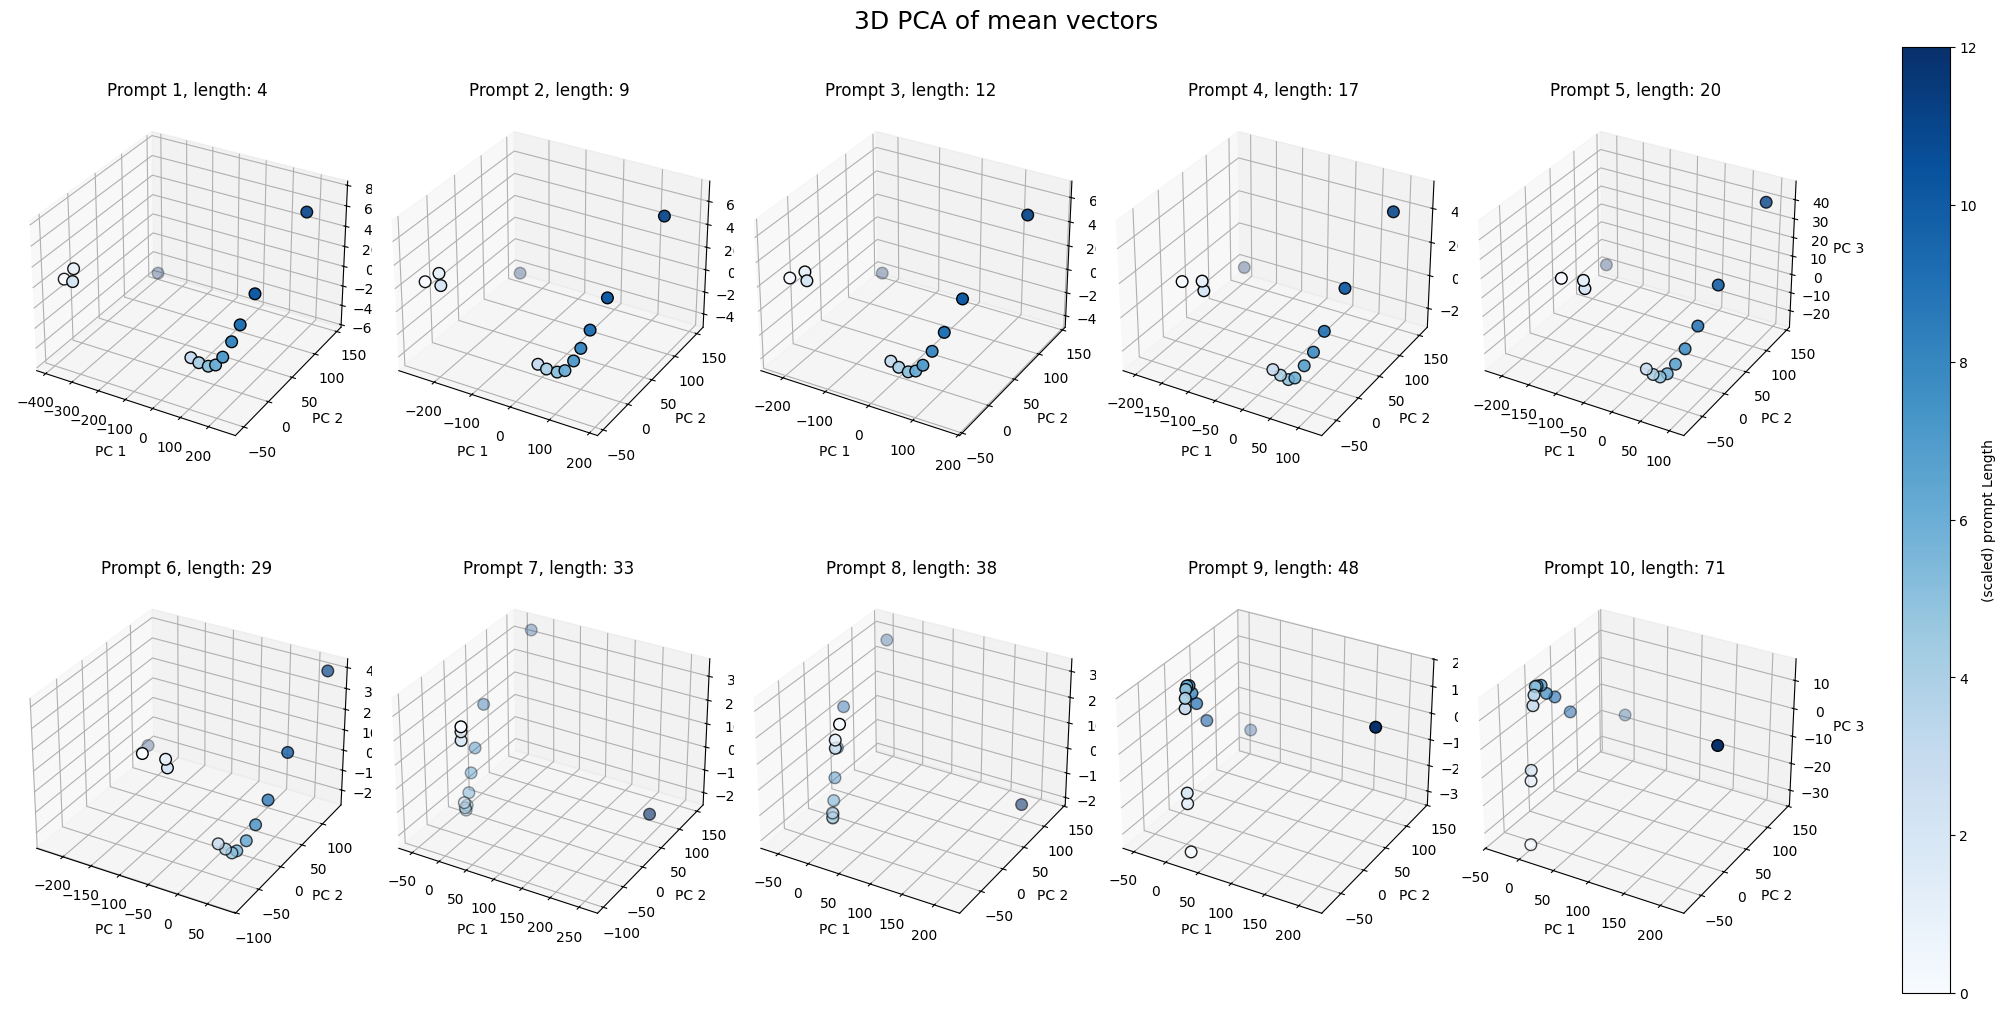

In [9]:
# Create subplots 
fig = plt.figure(figsize=(20, 10), constrained_layout=True)
axs = [fig.add_subplot(2, 5, i+1, projection='3d') for i in range(10)]

num_points = mean_vector.shape[1]
colors = np.arange(num_points)

for i in range(10):
    fixed_mean_vector = mean_vector[i, :, :]
    
    pca = PCA(n_components=3)
    proj = pca.fit_transform(fixed_mean_vector)
    
    scatter = axs[i].scatter(proj[:, 0], proj[:, 1], proj[:, 2], c=colors, cmap="Blues", s=70, edgecolor="black")
    axs[i].set_title(f"Prompt {i+1}, length: {word_counts[i]}")
    axs[i].set_xlabel("PC 1")
    axs[i].set_ylabel("PC 2")
    axs[i].set_zlabel("PC 3")

# Shared colorbar
fig.colorbar(scatter, ax=axs, label="(scaled) prompt Length", orientation='vertical')
fig.suptitle("3D PCA of mean vectors", fontsize=18)
plt.show()

In [10]:
ranks = []
for prompt, matrices in rank_matrix.items():
    for i, mat in enumerate(matrices):
        rank = matrix_rank(mat)
        ranks.append(rank/768)

print(np.round(ranks, 3)*100)

[ 0.8  1.3  1.7  2.7  3.3  4.   4.9  5.7  7.8 11.5]


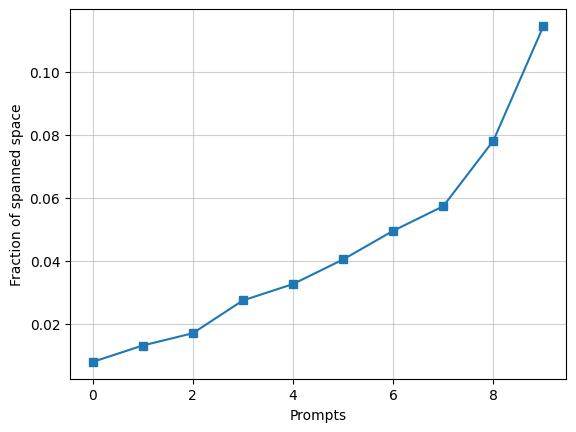

In [11]:
plt.plot(np.arange(len(ranks)), ranks, marker='s')
plt.xlabel("Prompts")
plt.ylabel("Fraction of spanned space")

plt.grid(alpha=0.6)
plt.show()

In [12]:
gd_heatmap = []
# Loop over the prompts
for p in prompts:
    # Define matrices to store the results for each prompt
    single_gd_heatmap = np.zeros((13,13))
    # Get the buffer state 
    buffer_states = get_buffer_states(p)

    # Loop over buffer steps
    for i in range(buffer_states.shape[0]):
        # Initial Grassmann reference buffer (from first step)
        buffer_scaled_0 = buffer_states[i,:,:] - np.mean(buffer_states[i,:,:], axis=0, keepdims=True)
        U, S, Vt = la.svd(buffer_scaled_0)
        eigenvalues = S**2
        explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
        n_components = np.argmax(np.cumsum(explained_variance_ratio) >= 0.9)+1
        
        #Low rank approximation
        U_reduced = U[:, :n_components]
        S_reduced = np.diag(S[:n_components])
        Vt_reduced = Vt[:n_components, :]
        buffer_reduced_0 = np.dot(np.dot(U_reduced, S_reduced), Vt_reduced)
        for j in range(buffer_states.shape[0]):
            bg = BufferGeometry(buffer_states[j, :, :])
            
            # Reduce current buffer
            buffer_scaled = buffer_states[j,:,:] - np.mean(buffer_states[j,:,:], axis=0, keepdims=True)
            U, S, Vt = la.svd(buffer_scaled)
            eigenvalues = S**2
            explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
            n_components = np.argmax(np.cumsum(explained_variance_ratio) >= 0.9)+1
            
            # Low rank approximation   
            U_reduced = U[:, :n_components]
            S_reduced = np.diag(S[:n_components])
            Vt_reduced = Vt[:n_components, :]
            buffer_reduced = np.dot(np.dot(U_reduced, S_reduced), Vt_reduced)

            # ===== GRASSMANN DISTANCE =====
            bg_reduced = BufferGeometry(buffer_reduced)
            single_gd_heatmap[i,j] = bg_reduced.grassmann_distance(buffer_reduced_0)
    
    # append heatmap matrix for that prompt
    gd_heatmap.append(single_gd_heatmap)

In [13]:
gd_heatmap = np.array(gd_heatmap)

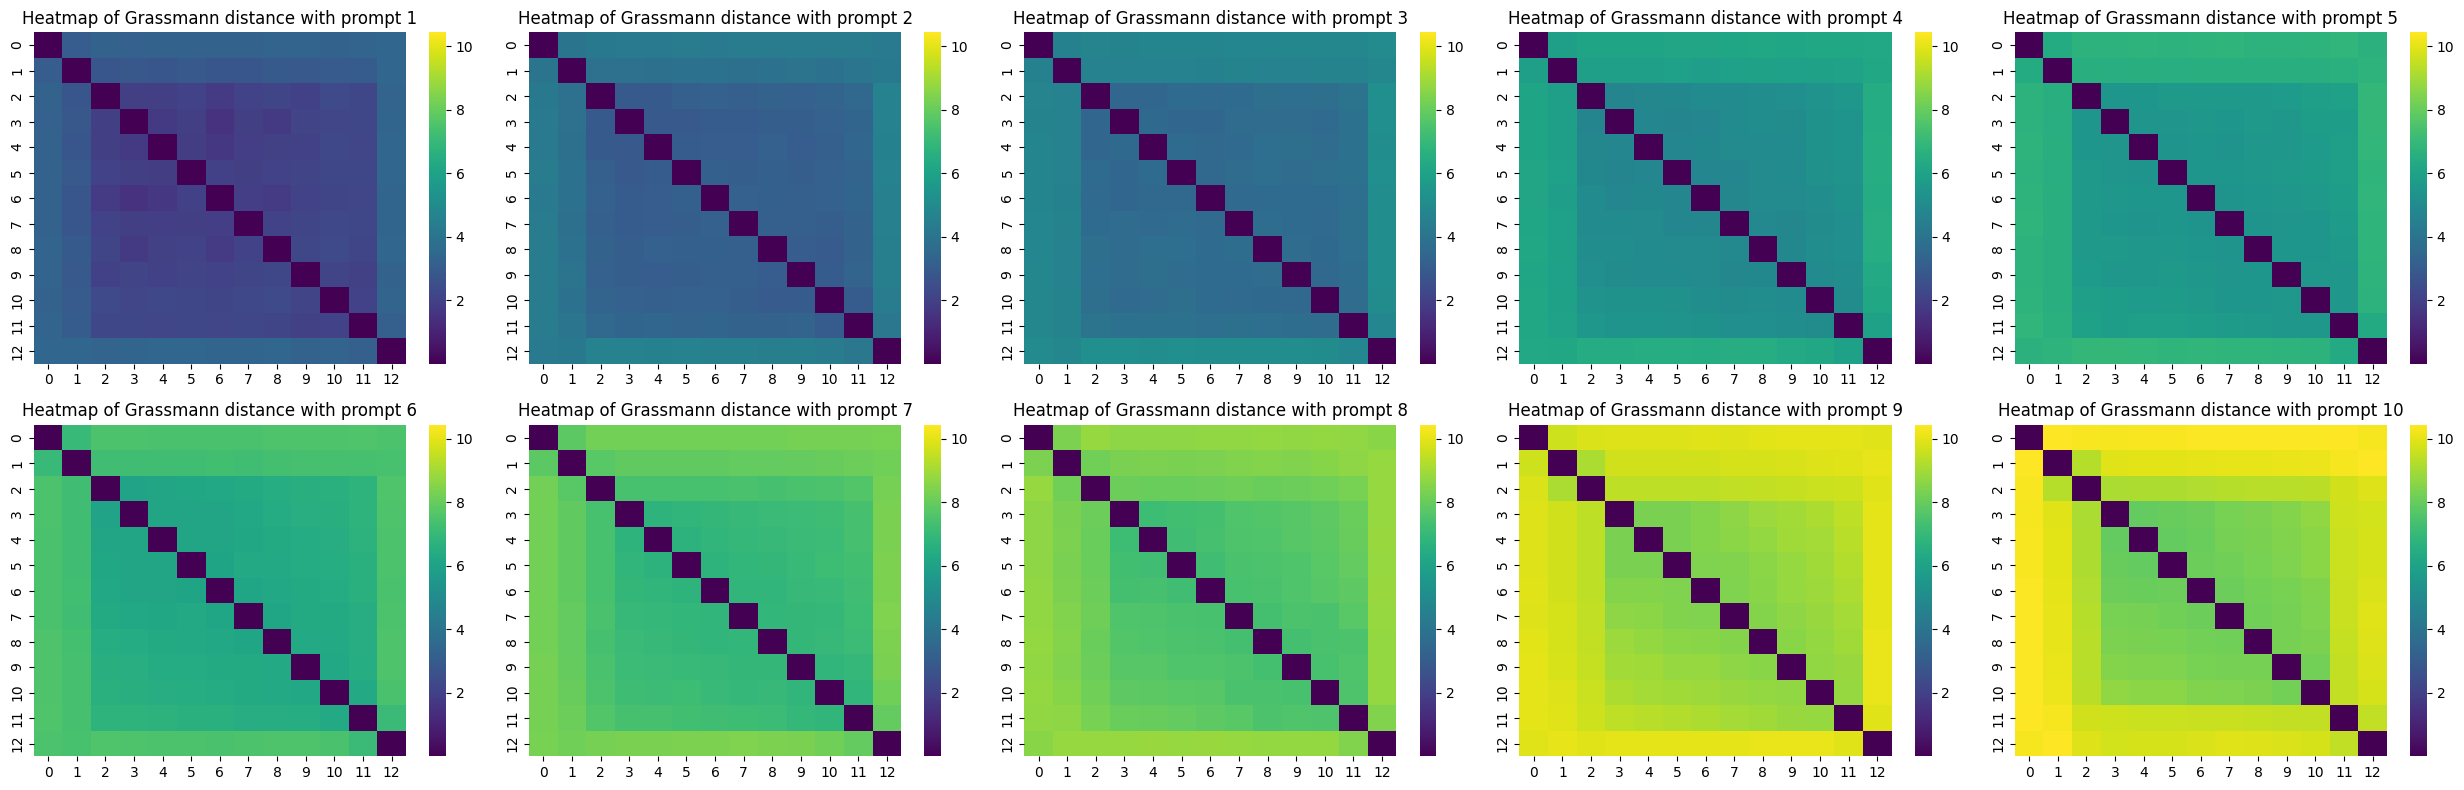

In [14]:
# Find global min and max across all heatmaps
vmin = np.min(gd_heatmap)
vmax = np.max(gd_heatmap)

fig, axes = plt.subplots(2, 5, figsize=(25, 8))
axes = axes.flatten()

for i in range(gd_heatmap.shape[0]):
    sns.heatmap(
        gd_heatmap[i],
        ax=axes[i],
        cmap='viridis',
        vmin=vmin,
        vmax=vmax
    )
    axes[i].set_title(f"Heatmap of Grassmann distance with prompt {i + 1}")

plt.tight_layout()
plt.show()